In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import pandas as pd
from datetime import datetime
import firebase_admin
from firebase_admin import db
from firebase_admin import credentials


In [2]:
### ONLY RUN ONCE! ###
#download data from firebase
cred = credentials.Certificate("../pc_basestation/fb_key.json")
firebase_admin.initialize_app(cred, {'databaseURL': 'https://haucs-monitoring-default-rtdb.firebaseio.com'})

In [40]:
## ONLY RUN TO REFRESH DATA! ###
ref = db.reference('/')
data = ref.get()

In [54]:
## information regarding sensor installments/removals
## ID - biomass sensor (not algae tank)
df = pd.read_csv('sensor_log.csv')
print(df.head())

## information regarding algae harvests
## Before - algae (kg) in tank before harvest
## After  - algae (kg) in tank after harvest
## ID - algae tank
df = pd.read_csv('harvest_log.csv')
print("\n", df.head())

                  Date  ID      Event  Value
0  2023-04-11T09:00:00   1    removed      1
1  2023-04-11T13:00:00   1  installed      2

                   Date  ID  Before  After
0  2023-02-03T12:00:00   3   39.71  22.11
1  2023-02-09T12:00:00   3   36.90  22.11
2  2023-02-16T12:00:00   3   46.30  22.11
3  2023-02-22T12:00:00   3   43.01  22.11
4  2023-03-02T12:00:00   3   44.40  22.11


In [42]:
### RUN TO SAVE JSON FILE LOCALLY ###
with open('latest_data.json', 'w') as f:
    json.dump(data, f)

In [43]:
class bmass_sensor():

    def __init__(self, name, data):
        self.d_dt = [datetime.fromisoformat(i) for i in data[name]['data']]
        self.s_dt = [datetime.fromisoformat(i) for i in data[name]['status']]
        self.on = np.array([int(data[name]['data'][i][1]) for i in data[name]['data']])
        self.off = np.array([int(data[name]['data'][i][0]) for i in data[name]['data']])
        self.g = np.array([int(data[name]['data'][i][2]) for i in data[name]['data']])
        self.battv = np.array([float(data[name]['status'][i]['batt_v']) for i in data[name]['status']])


bm1 = bmass_sensor('bmass_1', data)
bm2 = bmass_sensor('bmass_2', data)
bm3 = bmass_sensor('bmass_3', data)
bm4 = bmass_sensor('bmass_4', data)
bm5 = bmass_sensor('bmass_5', data)


In [50]:
print(bm5.d_dt[-1])
print(bm5.on[-1])
print(bm2.off[-1])
print(bm2.g[-1])

2023-04-11 13:46:42
682
366
5884


In [19]:
def moving_average(x, n=4):
    '''
    Simple moving average filter
    '''
    filter = np.ones(n) / n
    return np.convolve(x, filter, 'same')

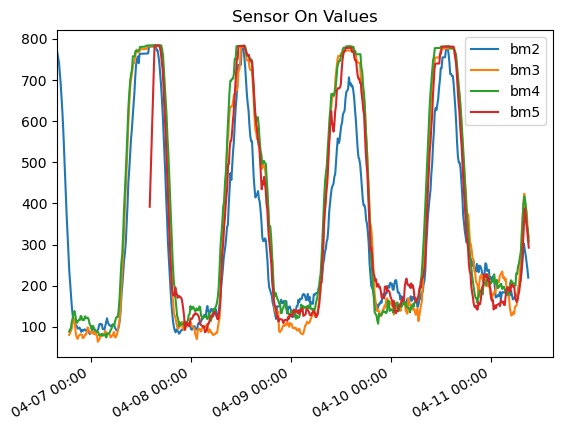

In [20]:
# Set date format for x-axis labels
date_fmt = '%m-%d %H:%M'
# Use DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)

bm2_t = mdates.date2num(bm2.d_dt)
bm3_t = mdates.date2num(bm3.d_dt)
bm4_t = mdates.date2num(bm4.d_dt)
bm5_t = mdates.date2num(bm5.d_dt)

lower = mdates.date2num(datetime(2023, 4, 6, hour=16))
#plot
plt.figure()
plt.plot(bm2_t, moving_average(bm2.on, 12))
plt.plot(bm3_t, moving_average(bm3.on, 12))
plt.plot(bm4_t, moving_average(bm4.on, 12))
plt.plot(bm5_t, moving_average(bm5.on, 12))
plt.xlim(left=lower)
# plt.ylim(top=400)
plt.title("Sensor On Values")
plt.legend(['bm2', 'bm3', 'bm4', 'bm5'])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.show()

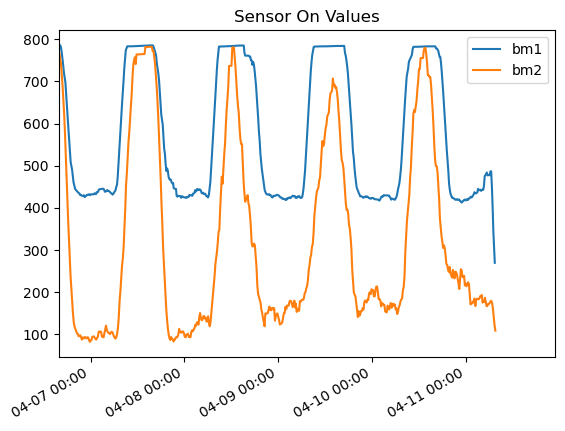

In [15]:
# Set date format for x-axis labels
date_fmt = '%m-%d %H:%M'
# Use DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)

bm1_t = mdates.date2num(bm1.d_dt)
bm2_t = mdates.date2num(bm2.d_dt)

lower = mdates.date2num(datetime(2023, 4, 6, hour=16))
#plot
plt.figure()
plt.plot(bm1_t, moving_average(bm1.on, 12))
plt.plot(bm2_t, moving_average(bm2.on, 12))
plt.xlim(left=lower)
# plt.ylim(top=400)
plt.title("Sensor On Values")
plt.legend(['bm1', 'bm2'])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.show()

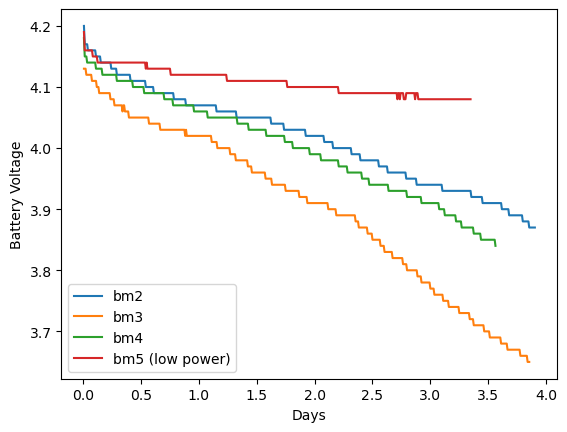

In [8]:
bm3_t = mdates.date2num(bm3.s_dt)
bm4_t = mdates.date2num(bm4.s_dt)
bm5_t = mdates.date2num(bm5.s_dt)

t = np.arange(1, len(bm2.battv) + 1) / 6 / 24
plt.figure()
plt.plot(t[:len(bm2.battv)], bm2.battv)
plt.plot(t[:len(bm3.battv)], bm3.battv)
plt.plot(t[:len(bm4.battv)], bm4.battv)
plt.plot(t[:len(bm5.battv)], bm5.battv)
plt.ylabel("Battery Voltage")
plt.xlabel("Days")
plt.legend(["bm2", "bm3", "bm4", "bm5 (low power)"], loc='lower left')
plt.show()

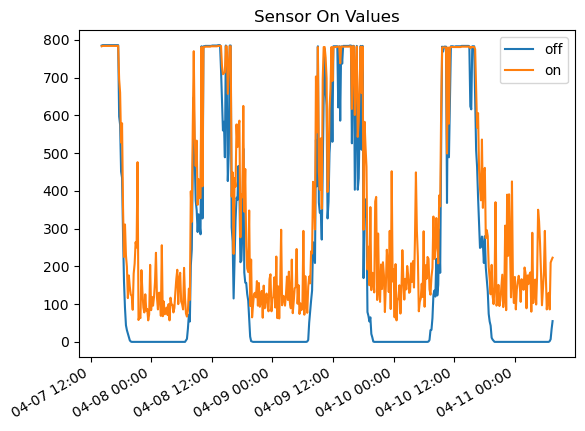

In [9]:
bm5_t = mdates.date2num(bm5.d_dt)
lower = mdates.date2num(datetime(2023, 4, 6, hour=16))
#plot
plt.figure()
plt.plot(bm5_t, bm5.off)
plt.plot(bm5_t, bm5.on)
# plt.xlim(left=lower)
# plt.ylim(top=400)
plt.title("Sensor On Values")
plt.legend(['off', 'on'])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.show()